In [86]:
# General tool for data analisys and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, LabelBinarizer, OrdinalEncoder
from sklearn.metrics import f1_score, make_scorer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import ColumnTransformer

In [87]:
# Import data set
df = pd.read_csv(r'.\data\kddcup_data_10_percent_corrected.csv')
validation_set = pd.read_csv(r'.\data_for_ML\validation_set.csv')
y_validation_set = pd.read_csv(r'.\data_for_ML\corrected_validation_set.csv')

## Data exploration, visualization, analysis and cleaning
To obtain the best possible predictive model, it is necessary to understand the data, visualize it and, if necessary, clean it. It will search for duplicate, null and atypical data, using different techniques such as imputation by mean or mode.

In [88]:
df.head()

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,...,9.1,1.00.1,0.00.6,0.11.1,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


#### It is observed that there is no name for the columns, these will be placed based on the KDD Cup 99 file in the same way we will add a new variable which is the type of attack on the network.

In [89]:
url_headears = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names'
names = requests.get(url_headears)

url_attack_type = 'http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types'
attack_type_text = requests.get(url_attack_type)

# Extraer y generar el array de columnas para colocar el header a nuestro dataframe
col_names = []
split_rows = names.text.split('\n')
for idx in range(1, len(split_rows)):
  col_name = split_rows[idx].split(':')[0]
  if idx == len(split_rows)-1:
    col_name = 'target'
  col_names.append(col_name)
  
# Target types data extraction
dict_attack_type = {}
types_text_split = attack_type_text.text.split()
for i in range(0, len(types_text_split)):
    if i < len(types_text_split) -1:
      dict_attack_type[types_text_split[i]] = types_text_split[i+1]
dict_attack_type['normal'] = 'normal'

# Colocal nombre de columnas
df.columns = col_names
y_validation_set.columns = col_names
# Agregar nueva columna de tipo de ataque en base al diccionario
df['target_type'] = df.target.apply(lambda x : dict_attack_type[x[0:-1]])
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,target,target_type
0,0,tcp,http,SF,239,486,0,0,0,0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0,tcp,http,SF,235,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0,tcp,http,SF,219,1337,0,0,0,0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


In [43]:
print("Size of the dataset \nRows : {} \nColumns : {}".format(df.shape[0],df.shape[1]))

Size of the dataset 
Rows : 494020 
Columns : 43


In [44]:
# encontrando duplicados en el dataset
duplicateRowsDF = df[df.duplicated()]
print('Duplicated data ' + str(len(duplicateRowsDF)) + ' rows are the same.')
# delete duplicate from dataset
df_noDuplicate = df.drop_duplicates(subset=None, keep='first', inplace=False)
print("Size of the dataset without duplicates \nRows : {} \nColumns : {}".format(df_noDuplicate.shape[0],df_noDuplicate.shape[1]))

Duplicated data 348435 rows are the same.
Size of the dataset without duplicates 
Rows : 145585 
Columns : 43


#### Despite having duplicate values, the decision was made to analyze and study if these are a bias for our predictive model. That is, two neural networks will be created, one with duplicate data and the other not to know which is the one that best predicts.

In [45]:
# analysis of the variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494020 entries, 0 to 494019
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494020 non-null  int64  
 1   protocol_type                494020 non-null  object 
 2   service                      494020 non-null  object 
 3   flag                         494020 non-null  object 
 4   src_bytes                    494020 non-null  int64  
 5   dst_bytes                    494020 non-null  int64  
 6   land                         494020 non-null  int64  
 7   wrong_fragment               494020 non-null  int64  
 8   urgent                       494020 non-null  int64  
 9   hot                          494020 non-null  int64  
 10  num_failed_logins            494020 non-null  int64  
 11  logged_in                    494020 non-null  int64  
 12  num_compromised              494020 non-null  int64  
 13 

##### Observations
* The dataset contains categorical and numeric variables: 4 categorical variables and the rest are numerical, and this numerical are divided in continuous and discrete data.
* There are not null values in our dataset.
* By having categorical variables we will have to apply techniques such as one hot-encoding or label enconding.

### Statistical analisys
We analyze measures of central tendency and dispersion to get a better idea of ​​our dataset.
##### Categorical variables

In [46]:
df.describe(include=['object']).T

,count,unique,top,freq
protocol_type,494020,3,icmp,283602
service,494020,66,ecr_i,281400
flag,494020,11,SF,378439
target,494020,23,smurf.,280790
target_type,494020,5,dos,391458


In [47]:
df['protocol_type'].value_counts()

icmp    283602
tcp     190064
udp      20354
Name: protocol_type, dtype: int64

<AxesSubplot:xlabel='protocol_type', ylabel='count'>

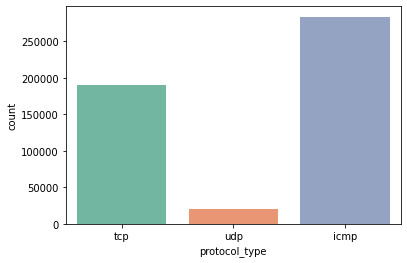

In [48]:
sns.countplot(x="protocol_type", data=df, palette="Set2")

In [49]:
df['service'].value_counts()

ecr_i      281400
private    110893
http        64292
smtp         9723
other        7237
            ...  
X11            11
tim_i           7
tftp_u          1
red_i           1
pm_dump         1
Name: service, Length: 66, dtype: int64

In [50]:
df['flag'].value_counts()

SF        378439
S0         87007
REJ        26875
RSTR         903
RSTO         579
SH           107
S1            57
S2            24
RSTOS0        11
S3            10
OTH            8
Name: flag, dtype: int64

<AxesSubplot:xlabel='flag', ylabel='count'>

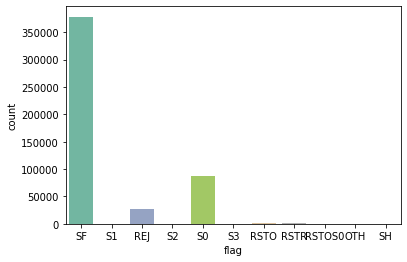

In [51]:
sns.countplot(x="flag", data=df, palette="Set2")

In [52]:
df['target'].value_counts()

smurf.              280790
neptune.            107201
normal.              97277
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: target, dtype: int64

### Analysis of the variable to predict (target_type)

In [53]:
df['target_type'].value_counts()

dos       391458
normal     97277
probe       4107
r2l         1126
u2r           52
Name: target_type, dtype: int64

* DOS: denial-of-service, e.g. syn flood;
* R2L: unauthorized access from a remote machine, e.g. guessing password;
* U2R:  unauthorized access to local superuser (root) privileges, e.g., various ``buffer overflow'' attacks;
* probing: surveillance and other probing, e.g., port scanning.

In [54]:
a = df['target_type'].value_counts()/len(df)
a

dos       0.792393
normal    0.196909
probe     0.008313
r2l       0.002279
u2r       0.000105
Name: target_type, dtype: float64

<AxesSubplot:xlabel='target_type', ylabel='count'>

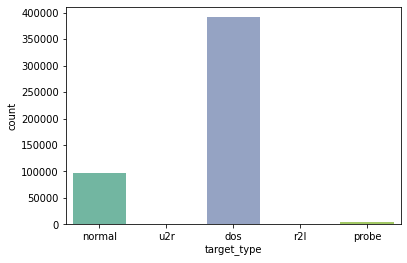

In [55]:
sns.countplot(x="target_type", data=df, palette="Set2")

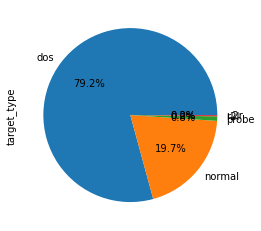

In [56]:
a.plot.pie(autopct="%.1f%%");

##### Observations target variable
* A large imbalance is observed in the dataset. In other words, the distribution of the data is in a single category, in this case 80% of the data are DOS attacks, 19% normal traffic and the other 1% divided between 3 other categories.
* Since the objective is to categorize if the connections are good, that is, without threats or bad, those that represent a threat or an attack, a new variable will be added that represents this value based on the "target_type" variable. Any type that is not normal is considered a threat or attack.


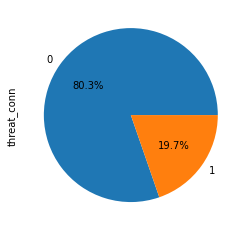

In [57]:
# add new feature to dataset if is 1 the connection is 
df['threat_conn'] = (df['target_type'] == 'normal') * 1
a = df['threat_conn'].value_counts()/len(df)
a.plot.pie(autopct="%.1f%%");

#### Numeical variables

In [58]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,494020.0,47.979400,707.747185,0.0,0.00,0.0,0.00,58329.0
src_bytes,494020.0,3025.616054,988219.101224,0.0,45.00,520.0,1032.00,693375640.0
dst_bytes,494020.0,868.523151,33040.034049,0.0,0.00,0.0,0.00,5155468.0
land,494020.0,0.000045,0.006673,0.0,0.00,0.0,0.00,1.0
wrong_fragment,494020.0,0.006433,0.134805,0.0,0.00,0.0,0.00,3.0
urgent,494020.0,0.000014,0.005510,0.0,0.00,0.0,0.00,3.0
hot,494020.0,0.034519,0.782103,0.0,0.00,0.0,0.00,30.0
num_failed_logins,494020.0,0.000152,0.015520,0.0,0.00,0.0,0.00,5.0
logged_in,494020.0,0.148245,0.355343,0.0,0.00,0.0,0.00,1.0
num_compromised,494020.0,0.010212,1.798328,0.0,0.00,0.0,0.00,884.0


array([[<AxesSubplot:title={'center':'duration'}>,
        <AxesSubplot:title={'center':'src_bytes'}>,
        <AxesSubplot:title={'center':'dst_bytes'}>,
        <AxesSubplot:title={'center':'land'}>,
        <AxesSubplot:title={'center':'wrong_fragment'}>,
        <AxesSubplot:title={'center':'urgent'}>],
       [<AxesSubplot:title={'center':'hot'}>,
        <AxesSubplot:title={'center':'num_failed_logins'}>,
        <AxesSubplot:title={'center':'logged_in'}>,
        <AxesSubplot:title={'center':'num_compromised'}>,
        <AxesSubplot:title={'center':'root_shell'}>,
        <AxesSubplot:title={'center':'su_attempted'}>],
       [<AxesSubplot:title={'center':'num_root'}>,
        <AxesSubplot:title={'center':'num_file_creations'}>,
        <AxesSubplot:title={'center':'num_shells'}>,
        <AxesSubplot:title={'center':'num_access_files'}>,
        <AxesSubplot:title={'center':'num_outbound_cmds'}>,
        <AxesSubplot:title={'center':'is_host_login'}>],
       [<AxesSubplot:titl

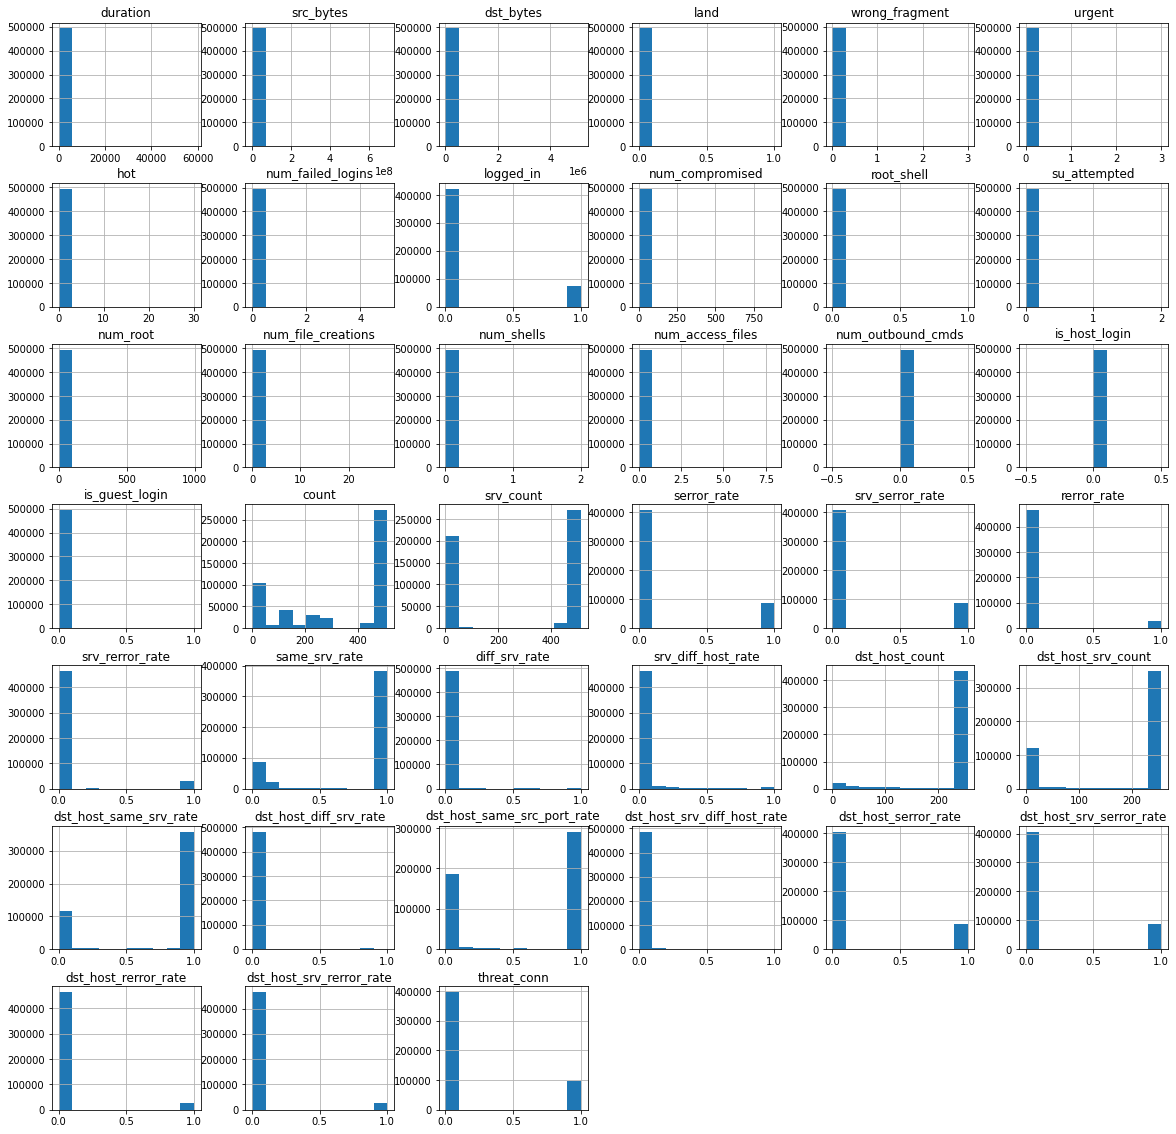

In [59]:
df.hist(figsize=(20,20),bins=10)

In [60]:
def dispersion_mesures(df):
    return pd.concat([
                      df.mad().rename('mad'),
                      df.skew().rename('skew'),
                      df.kurt().rename('kurt'),
                        
                     ], axis=1).T

dispersion_mesures(df).T

,mad,skew,kurt
duration,94.774582,25.864831,942.528333
src_bytes,4806.576365,699.212443,490583.352581
dst_bytes,1535.036833,136.759149,20338.103955
land,0.000089,149.841886,22450.681826
wrong_fragment,0.012834,21.718907,476.086558
urgent,0.000028,447.646551,217366.270210
hot,0.068592,32.629112,1127.014947
num_failed_logins,0.000304,160.802454,37221.521736
logged_in,0.252537,1.979813,1.919668
num_compromised,0.020332,417.529806,188120.966915


<AxesSubplot:>

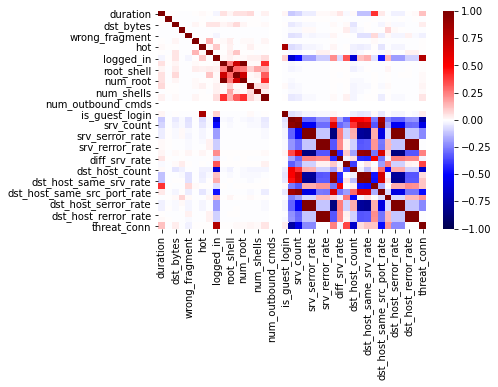

In [61]:
sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap='seismic')

### Outliers analysis

<AxesSubplot:xlabel='duration'>

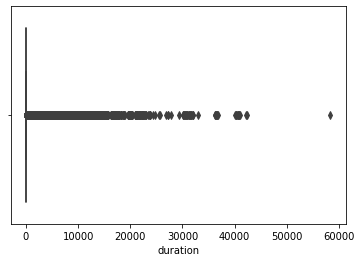

In [62]:
sns.boxplot(x=df["duration"])

##### Observations
* Based on our measures of dispersion and central tendency, we can conclude that there is a great dispersion between the data, however, we will not choose to normalize or handle atypical data since they are correct values ​​of connections that entered our network, so to do our model as close to reality we will leave these values. If in case our model is very poor, that is, it predicts very badly, the elimination of these values ​​will be taken into account and normalize them.
* Mean Absolute Deviation (MAD) of a dataset is the average distance between each data point and the mean.
Skewness is a measure of symmetry, or more precisely, the lack of symmetry. A distribution, or data set, is symmetric if it looks the same to the left and right of the center point. Tells you the amount and direction of skew (departure from horizontal symmetry)
* Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution. Tells you how tall and sharp the central peak is, relative to a standard bell curve.
* Testing for normality: many statistics inferences require that a distribution be normal or nearly normal. A normal distribution has skewness and excess kurtosis of 0, so if your distribution is close to those values then it is probably close to normal.

In [63]:
def countNull(dataFrame):
    "Funcion que recibe un dataframe para devolver un dataframe resumiendo los valores nulos de estos"
    null_count = dataFrame.isnull().sum()
    null_percentage = dataFrame.isnull().sum() * 100 / len(dataFrame)
    table_null = pd.DataFrame({'column_name': dataFrame.columns, 'null_count': null_count,'percent_missing': null_percentage}).reset_index(drop=True)
    return table_null

countNull(df)

,column_name,null_count,percent_missing
0,duration,0,0.0
1,protocol_type,0,0.0
2,service,0,0.0
3,flag,0,0.0
4,src_bytes,0,0.0
5,dst_bytes,0,0.0
6,land,0,0.0
7,wrong_fragment,0,0.0
8,urgent,0,0.0
9,hot,0,0.0


#### Observations:
* the dataset does not contain null values

## Machine Learning
In this section of the code we find all the models that we will train to make a decision which model is the best.

### Management of categorical variables (One hot Encoder)
The One hot finding technique will be used, which consists of transforming the categorical data into numerical data and placing them in a type t and dy. This causes multiple new columns to be generated.

In [64]:
df_machine_learning = df
def one_hot_encoder(data, feature):
    get_dummies = pd.get_dummies(data[feature])
    for x in get_dummies.columns:
        dummy_name = f"{feature}-{x}"
        data[dummy_name] = get_dummies[x]
    data.drop(feature, axis=1, inplace=True)
    return None

In [65]:
categorical_cols = df_machine_learning.select_dtypes(include=["object"]).columns 
# Convertir mis columunas categoricas en numericas con la tecnica de One Hot Enconding
for feature in categorical_cols:
    if feature not in ['target', 'target_type']:
        one_hot_encoder(df_machine_learning, feature)

In [66]:
print("Size of the dataset for machine learning using One Hot Enconding \nRows : {} \nColumns : {}".format(df_machine_learning.shape[0],df_machine_learning.shape[1]))

Size of the dataset for machine learning using One Hot Enconding 
Rows : 494020 
Columns : 121


#### Separating target variables from the dataset

In [67]:
# Machine Learning
X = df_machine_learning.drop(['target','target_type', 'threat_conn'], axis=1)
y = df_machine_learning['threat_conn']

In [68]:
print("Size of x dataset " + str(X.shape))
print("Size of y dataset " + str(y.shape))

Size of x dataset (494020, 118)
Size of y dataset (494020,)


#### Separating train and test data

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [70]:
print("Size of the training dataset \nRows : {} \nColumns : {}".format(X_train.shape[0],X_train.shape[1]))
print("Size of the training target variable " + str(y_train.shape))
print("Size of the testing dataset \nRows : {} \nColumns : {}".format(X_test.shape[0],X_test.shape[1]))

Size of the training dataset 
Rows : 345814 
Columns : 118
Size of the training target variable (345814,)
Size of the testing dataset 
Rows : 148206 
Columns : 118


In [75]:
X_train.to_csv (r'.\data_for_ML\X_train_kdd.csv', index = False, header=True)
X_test.to_csv (r'.\data_for_ML\X_test_kdd.csv', index = False, header=True)
df.to_csv (r'.\data_for_ML\all_kdd.csv', index = False, header=True)

In [72]:
y_train.to_csv (r'.\data_for_ML\y_train_kdd.csv', index = False, header=False)
y_test.to_csv (r'.\data_for_ML\y_test_kdd.csv', index = False, header=False)

### validation Set
This is a data set that the model has never seen and does not belong to or is related to the test data set either

In [73]:
validation_set.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,0,190,1630,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,308,1434,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1032,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [98]:
y_validation_set['threat_conn'] = (y_validation_set['target'] == 'normal.') * 1
y_validation_set['threat_conn'].value_counts()

0    250436
1     60592
Name: threat_conn, dtype: int64

In [103]:
xx = y_validation_set['threat_conn']
xx.to_csv (r'.\data_for_ML\y_ml_validation.csv', index = False, header=True)
print(len(xx))
print(len(validation_set))

311028
345814


## Neural network programming
#### The programming and training of the neural networks was done with Google collaboratory using GPU and Parallelism. This can be found in my github notebook.
